# Progetto di Analisi di Immagini e Video
----

-----
Il seguente notebook contiene le prove principali effettuate sulle reti addestrate.

L'attenzione è stata concentrata sulle seguenti architetture:


1.   C3D
2.   R3D
3. R(2+1)D




## Configurazione del notebook

In [ ]:
!nvidia-smi

Sun Jun 28 20:43:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import Libraries


In [ ]:
SEED = 9126

import os
import json
import time
from datetime import datetime
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import sys

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
from matplotlib import animation
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from collections import Counter

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
numFrames=16

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

run on cuda


In [ ]:
#path di dove si trovano i modelli preaddestrati
path_checks='/content/drive/My Drive/spacejam/modelliProve/'

## Caricamento Dataset

In [ ]:
#Da modificare a seconda della locazione della cartella Drive spacejam.
rootPath = 'drive/My Drive/spacejam'

In [ ]:
TRAIN_FILE = 'train_video'
TEST_FILE = 'test_video'
KEYSET_FILE = rootPath+'/testset_keys.txt'


labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" ,
          9: "walk" ,10: "discard"}

with open(os.path.join(rootPath, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)

In [ ]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

print(f'Il numero totale di elementi è pari a {len(annotations)}, di cui:\n{len(annotationTrain)} appartenendi al Training Set \n{len(annotationTest)} appartenenti al Test Set')

Il numero totale di elementi è pari a 37085, di cui:
25959 appartenendi al Training Set 
11126 appartenenti al Test Set


Sulla base degli elementi contenuti in *annotationTrain* e *annotationTest*, il dataset è stato suddiviso in due zip contenenti Training Set e Test Set per agevolare il lavoro di caricamento.

Si procede con il caricamento tramite unzip.



In [ ]:
rootPath = 'drive/My\ Drive/spacejam'
!unzip -x $rootPath'/train_video.zip'
!unzip -x $rootPath'/test_video.zip'

Streaming output truncated to the last 5000 lines.
  inflating: test_video/0017045.mp4  
  inflating: test_video/0026512.mp4  
  inflating: test_video/0005333.mp4  
  inflating: test_video/0032824.mp4  
  inflating: test_video/0004259.mp4  
  inflating: test_video/0025146.mp4  
  inflating: test_video/0002699.mp4  
  inflating: test_video/0013247.mp4  
  inflating: test_video/0007801.mp4  
  inflating: test_video/0023308.mp4  
  inflating: test_video/0000698.mp4  
  inflating: test_video/0031482.mp4  
  inflating: test_video/0009713.mp4  
  inflating: test_video/0011998.mp4  
  inflating: test_video/0032465.mp4  
  inflating: test_video/0018012_flipped.mp4  
  inflating: test_video/0000303.mp4  
  inflating: test_video/0003400.mp4  
  inflating: test_video/0031819.mp4  
  inflating: test_video/0029458_flipped.mp4  
  inflating: test_video/0014106.mp4  
  inflating: test_video/0025501.mp4  
  inflating: test_video/0035294.mp4  
  inflating: test_video/0034588.mp4  
  inflating: test_vid

A titolo di esempio vengono mostrati 2 frame estratti da uno dei video contenuti nel dataset.

Shape torch.Size([16, 3, 176, 128])


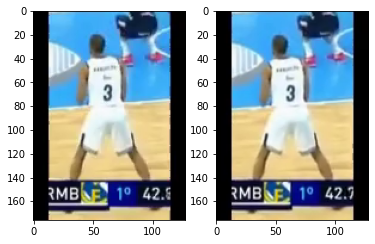

In [ ]:
transform = torchvision.transforms.ToTensor()

image = []

fname = os.path.join(TRAIN_FILE, '0018414.mp4')
video = cv2.VideoCapture(fname)
while (True):
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame = transform(Image.fromarray(frame))
        # print(frame.dtype)
        image.append(frame.unsqueeze(0))
    else:
        break
image = torch.cat(image, axis=0)

print('Shape', image.shape)

plt.subplot(121)
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(image[1].numpy().transpose(1, 2, 0));

## Distribuzione delle classi
Dal plot della distribuzione delle classi, si può notare come il dataset risulta fortemente sbilanciato, con minoranza delle classi: *shoot*, *pick*, *block* e *pass*

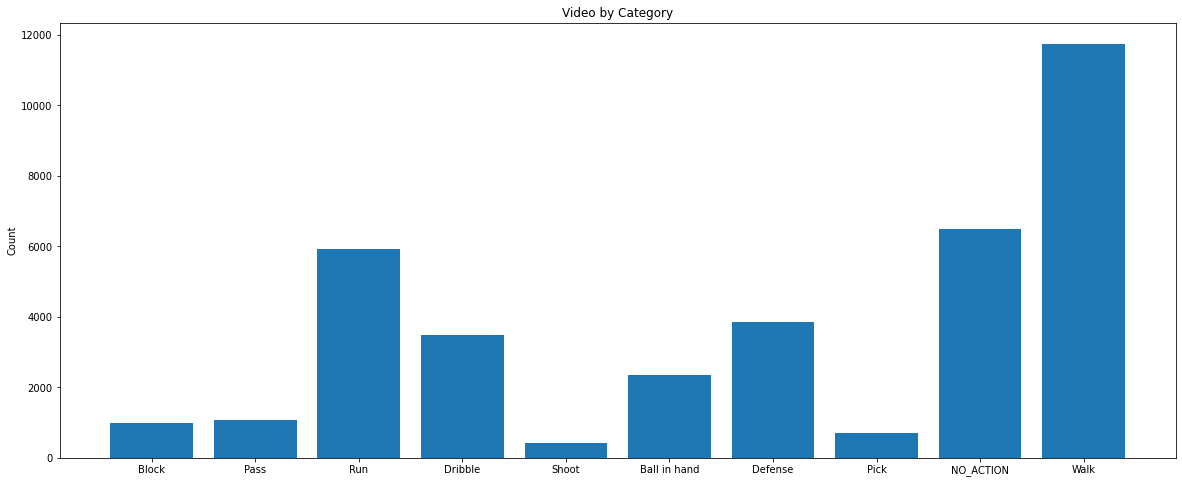

In [ ]:
tmp = Counter(list(annotations.values()))
occurrences = dict(tmp)

x = [k for k, v in occurrences.items()]
y = [v for k, v in occurrences.items()]
fig = plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.xticks(np.arange(10), ["Block","Pass","Run","Dribble","Shoot","Ball in hand","Defense","Pick","NO_ACTION","Walk"])
plt.ylabel('Count')
plt.title('Video by Category')
plt.savefig("dataset_distribution.png")

## Creazione Dataset
A partire dai path dei video in annotationTrain e annotationTest definito il modulo per la creazione del dataset che verrà poi caricato tramite DataLoader. Durante la creazione vengono estratti i 16 frame sono state inserite diverse manipolazioni dei tensori, a seconda del preprocessing scelto. In particolare, queste riguardano:


1.   RandomCrop
2.   Normalization
3.   Resize
4.   Aspect ratio




In [ ]:

from glob import glob

#il metodo di normalize è stato ridefinito seguendo le linee guida di pytorch per ottenere dei valori compresi tra 0 ed 1
def normalize(vid, mean, std):
  shape = (-1,) + (1,) * (vid.dim() - 1)
  mean = torch.as_tensor(mean).reshape(shape)
  std = torch.as_tensor(std).reshape(shape)
  return (vid *std) / mean

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std



    def __call__(self, vid):
        return normalize(vid, self.mean, self.std)


#La classe SpaceJamDataset permette di ottenere i tensori dei frame dei video.
class SpaceJamDataset(Dataset):
  def __init__(self, videoNames, labels, path, size, crop=2):
    self.videoNames = videoNames
    self.labels = labels
    self.path = path
    self.size = size
    self.crop=crop

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    transform = torchvision.transforms.ToTensor()
    name = self.videoNames[index]
    images=[]
    videoName = os.path.join(self.path,name+'.mp4')
    video = cv2.VideoCapture(videoName)
    while(True):
      ret, frame = video.read()
      if ret:
        dim = (self.size, self.size)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        norm=Normalize(mean=[0.43216, 0.394666, 0.37645],std=[0.22803, 0.22145, 0.216989])
        transform_train=None
        if self.crop==1:
          transform_train = torchvision.transforms.Compose([
            torchvision.transforms.Resize(128, 171),
            torchvision.transforms.RandomCrop(dim),
            torchvision.transforms.ToTensor(),
            norm
          ])
        elif self.crop==0:
          transform_train = torchvision.transforms.Compose([
            torchvision.transforms.Resize(dim),
            torchvision.transforms.ToTensor(),
            norm
          ])
        else:
           transform_train = torchvision.transforms.Compose([
            torchvision.transforms.Resize(dim),
            torchvision.transforms.ToTensor(),
          ])

        frame = transform_train(Image.fromarray(frame))
        images.append(frame.unsqueeze(0))
      else:
        break
    images = torch.cat(images, axis=0)
    if(self.path=='train_video'):
      return images, torch.tensor(annotationTrain.get(name))

    return images, torch.tensor(annotationTest.get(name))

In [ ]:
#E' stata definita un ulteriore classe di caricamento del dataset che riguarda l'applicazione 'same aspect ratio'.
class SpaceJamDatasetSAR(Dataset):
  def __init__(self, videoNames, labels, path, size):
    self.videoNames = videoNames #list(annotationTrain.keys())
    self.labels = labels
    self.path = path
    self.size = size

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    transform = torchvision.transforms.ToTensor()
    name = self.videoNames[index]
    images=[]
    videoName = os.path.join(self.path,name+'.mp4')
    video = cv2.VideoCapture(videoName)
    while(True):
      ret, frame = video.read()
      if ret:
        dim = (self.size, self.size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        #Getting the bigger side of the image
        s = max(frame.shape[0:2])
        #Creating a dark square with NUMPY
        f = np.zeros((s,s,3),np.uint8)
        #Getting the centering position
        ax,ay = (s - frame.shape[1])//2,(s - frame.shape[0])//2

        #Pasting the 'image' in a centering position
        f[ay:frame.shape[0]+ay,ax:ax+frame.shape[1]] = frame
        frame = cv2.resize(f,dim)
        frame = transform(Image.fromarray(frame))
        images.append(frame.unsqueeze(0))
      else:
        break
    images = torch.cat(images, axis=0)
    if(self.path=='train_video'):
      return images, torch.tensor(annotationTrain.get(name))

    return images, torch.tensor(annotationTest.get(name))


## Metodi di utilità

In [ ]:
#Il metodo save_ckp è stato utilizzato per salvare il checkpoint dei modelli
def save_ckp(state, checkpoint_path):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    """
    f_path = checkpoint_path+"/model.ckpt"
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

In [ ]:
#Il metodo load_ckp è stato utilizzato per caricare il checkpoint dei modelli
def load_ckp(checkpoint_path, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_path+"/model.ckpt")
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [ ]:
import time
from torch.autograd import Variable
from datetime import timedelta
import sys

#Il metodo call_train è stato definito per mandare in run il training di un modello:
#esso prevede la valuatzione sia sul training che sul test
def call_train(model, checkpoint_path,optimizer,start_epoch, totEpoch):
  cls_criterion = nn.CrossEntropyLoss().to(device)
  acc_tmp = 0
  for epoch in range(start_epoch, totEpoch+1):
    out_loss_train = open(checkpoint_path+"/lossTrain.txt", "a") #
    out_acc_train = open(checkpoint_path+"/accuracyTrain.txt", "a") #

    out_loss_test = open(checkpoint_path+"/lossTest.txt", "a") #
    out_acc_test = open(checkpoint_path+"/accuracyTest.txt", "a") #
    epoch_metrics = {"loss": [], "acc": []}
    epoch_metrics_test = {"loss": [], "acc": []}
    prev_time = time.time()
    print("----------------------")
    print(f"--- Epoch {epoch} ---")
    for batch_i, (X, y) in enumerate(trainLoader):

      image_sequences = X.view(X.size(0),3,16,X.size(3),X.size(4)).to(device)
      labels = y.to(device)
      optimizer.zero_grad()

      # Get sequence predictions
      predictions = model(image_sequences)

      # Compute metrics
      loss = cls_criterion(predictions, labels)
      acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()

      loss.backward()
      optimizer.step()

      # Keep track of epoch metrics
      epoch_metrics["loss"].append(loss.item())
      epoch_metrics["acc"].append(acc)

      # Determine approximate time left
      batches_done = epoch * len(trainLoader) + batch_i
      batches_left = (totEpoch+1) * len(trainLoader) - batches_done
      time_left = timedelta(seconds=batches_left * (time.time() - prev_time))
      prev_time = time.time()

      # Print log
      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] ETA: %s"
          % (
              epoch,
              totEpoch,
              batch_i,
              len(trainLoader),
              loss.item(),
              np.mean(epoch_metrics["loss"]),
              acc,
              np.mean(epoch_metrics["acc"]),
              time_left
          )
      )
    acc_tmp = np.mean(epoch_metrics["acc"])
    loss_tmp = np.mean(epoch_metrics["loss"])



    correct_test = 0
    total_test = 0
    predictions_test = []
    labels_list_test = []
    loss2_test = 0
    with torch.no_grad():
        for batch_i,data in enumerate(testLoader):

            images, labels = data
            images = images.view(images.size(0),3,16, images.size(3), images.size(4)).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss_test = cls_criterion(outputs, labels)
            acc_test = 100 * (outputs.detach().argmax(1) == labels).cpu().numpy().mean()


            epoch_metrics_test["loss"].append(loss_test.item())
            epoch_metrics_test["acc"].append(acc_test)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            labels_list_test.extend(labels.cpu().numpy())
            predictions_test.extend(predicted.cpu().numpy())
            correct_test += (predicted == labels).sum().item()
            sys.stdout.write(
              f"\rEpoch: {epoch} -- Acc Train: {acc_tmp} ---- [{batch_i}/{len(testLoader)}] Accuracy Test: {100 * correct_test / total_test} ")
    acc_tmp_test = np.mean(epoch_metrics_test["acc"])
    loss_tmp_test = np.mean(epoch_metrics_test["loss"])
    sys.stdout.write(f' \r Acc Train: {"{:.2f}".format(acc_tmp)}% -- Acc Test {"{:.2f}".format(acc_tmp_test)}%')

    checkpoint = {
      'epoch': epoch + 1,
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict(),
    }

    out_loss_train.write('{} Loss: {:.4f}\n'.format(epoch, loss_tmp)) #
    out_acc_train.write('{} ACC: {:.4f}\n'.format(epoch, acc_tmp)) #

    out_loss_test.write('{} Loss: {:.4f}\n'.format(epoch, loss_tmp_test)) #
    out_acc_test.write('{} ACC: {:.4f}\n'.format(epoch, acc_tmp_test)) #

    out_acc_test.close() #
    out_acc_train.close() #

    out_loss_test.close() #
    out_loss_train.close() #

    save_ckp(checkpoint, checkpoint_path)

In [ ]:
#getMetrics è stato utilizzato per ottenere da file di testo o csv i valori di accuracy e loss dei modelli.
#Questo al fine di poter plottare le curve di riferimento.
def getMetrics(model_path, set, type='txt'):

  def getMetrics_txt(model_path, set):
    if set == 'train':
      accPath = model_path+"/accuracyTrain.txt"
      lossPath = model_path+"/lossTrain.txt"

      accFile = open(accPath,'r')
      lossFile = open(lossPath,'r')
      acc = accFile.readlines()
      loss = lossFile.readlines()

      acc= ["{:.2f}".format(float(el.replace('\n','').split()[-1])) for el in acc]
      loss = ["{:.2f}".format(float(el.replace('\n','').split()[-1])) for el in loss]

      accFile.close()
      lossFile.close()

      return np.array(acc).astype(float), np.array(loss).astype(float)

    if set=='test':
      accPath = model_path+"/accuracyTest.txt"
      lossPath = model_path+"/lossTest.txt"

      accFile = open(accPath,'r')
      lossFile = open(lossPath,'r')
      acc = accFile.readlines()
      loss = lossFile.readlines()

      acc= ["{:.2f}".format(float(el.split()[-1])) for el in acc]
      loss = ["{:.2f}".format(float(el.split()[-1])) for el in loss]

      accFile.close()
      lossFile.close()

      return np.array(acc).astype(float), np.array(loss).astype(float)

    raise ValueError("I set disponibili sono 'train' o 'test'")

  def getMetrics_csv(model_path,set): #da cambiare quando mettiamo tutto in una cartella
    if set=='train':
      csv= pd.read_csv(model_path+'Train.csv')
      acc = csv[' acc']
      loss = csv['loss']
      return np.array(acc).astype(float), np.array(loss).astype(float)
    if set=='test':
      csv= pd.read_csv(model_path+'Test.csv')
      acc = csv[' acc']
      loss = csv['loss']
      return np.array(acc).astype(float), np.array(loss).astype(float)
    raise ValueError("I set disponibili sono 'train' o 'test'")



  if type=='txt':
    return getMetrics_txt(model_path, set)
  if type == 'csv':
    return getMetrics_csv(model_path,set)
  raise ValueError("Il tipo di file da caricare è diverso da 'txt' o 'csv'")






In [ ]:
#Il metodo plot si occupa di plottare le loss e le accuracy  dei modelli
def plot(modelPath , step, type='txt'):
  accTrain, lossTrain = getMetrics(modelPath, 'train', type)
  accTest, lossTest = getMetrics(modelPath, 'test', type)
  #epochs = np.arange(1,len(accTrain)+1)
  epochs =  np.linspace(0, len(accTrain), len(accTrain))
  fig = plt.figure(figsize=(15,7))
  fig.add_subplot(1,2,1)
  plt.plot(epochs, accTrain, c='b', label="Accuracy Train")
  plt.plot(epochs, accTest, c='g', label ="Accuracy Test")
  plt.title("Accuracy")
  plt.xticks(range(0,len(accTrain)+1,step))
  plt.legend(loc="lower right")

  fig.add_subplot(1,2,2)
  plt.plot(epochs, lossTrain, c='orange', label = "Loss Train")
  plt.plot(epochs, lossTest, c='r', label = "Loss Test")
  plt.title("Loss")
  plt.xticks(range(0,len(lossTrain)+1,step))
  plt.legend(loc="upper right")


In [ ]:
#Il metodo laod_model carica il modello con l'utilizzo di un optimizer predefinito
def load_model(model_architecture, checkpoint_path):
  model = model_architecture
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
  load_model,optimizer, start_epoch=load_ckp(checkpoint_path, model, optimizer)
  return load_model

In [ ]:
#Il metodo classify si occupa dell'applicazione del modello al test set.
def classify(model, dataset):
  correct = 0
  total = 0
  predictions = []
  y_true = []
  with torch.no_grad():
      for batch_i,data in enumerate(dataset):
          sys.stdout.write(
              f"\r{batch_i}/{len(dataset)}"
          )
          images, labels = data
          images = images.view(images.size(0),3,16, images.size(3), images.size(4)).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          y_true.extend(labels.cpu().numpy())
          predictions.extend(predicted.cpu().numpy())
          correct += (predicted == labels).sum().item()

  print(f'\n Accuracy della rete composta da {len(annotationTest)} video: {100* correct/total}')

  return y_true, predictions


In [ ]:
#bar_plot viene utilizzato per plottare il grafico a barra sui confronti
def bar_plot(values, names, nameNetwork):
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(names,values, label=['type', 'precision'])
  plt.xticks(rotation=40)
  plt.title("Confronto sui modelli per " + nameNetwork)
  plt.show()

#C3D
---
La prima architettura presa in analisi è la C3D: è composta da 8 livelli convoluzionali, 5 livelli di pooling e 2 fully-connected. I kernel convoluzionali sono 3x3x3 mentre i kernel di pooling sono 2x2x2.

Sono state applicate due diverse procedure di addestramento:
1. senza transfer learning;
2. transfer learning su Sport 1M.

## C3D senza transfer learning

Come primo tentativo viene allenata da 0 la rete C3D basandoci sui soli video provenienti dal dataset SpaceJam.

In [ ]:
class C3D(nn.Module):
    def __init__(self):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 10)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

    def forward(self, x):

        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        logits = self.fc8(h)

        return logits


In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'c3d_noTransferLearning'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

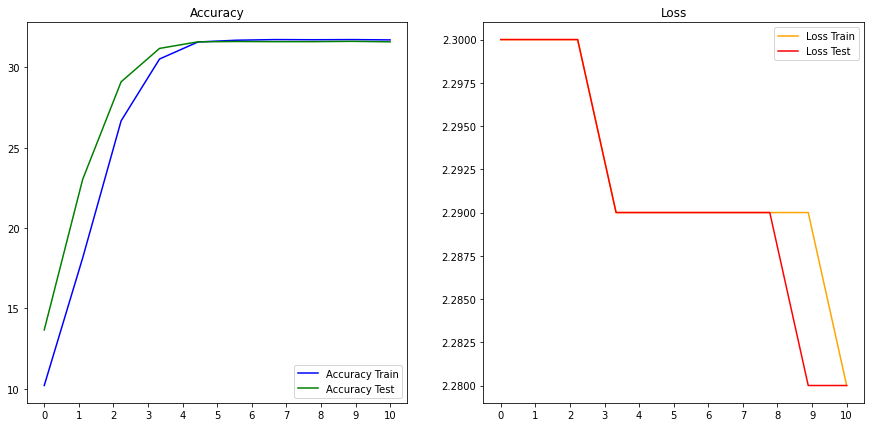

In [ ]:
plot(checkpoint_path, 1)

Possiamo notare come il modello arriva a convergenza già dopo la quarta epoca.


Otteniamo delle performance molto basse, raggiungendo circa il 32% di accuracy sia sul training set che sul test set.

Alzando il learning rate arriverebbe alle stesse performance ma in un numero di epoche minore.

### Test suite

In [ ]:
numBatch = 32
size = 120

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(C3D(), checkpoint_path).to(device)

In [ ]:
y_true, y_pred = classify(model, testLoader)

347/348
 Accuracy della rete composta da 11126 video: 31.583677871651986


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.00      0.00      0.00       297
           2       0.00      0.00      0.00      1827
           3       0.00      0.00      0.00      1060
           4       0.00      0.00      0.00       128
           5       0.00      0.00      0.00       678
           6       0.00      0.00      0.00      1181
           7       0.00      0.00      0.00       207
           8       0.00      0.00      0.00      1962
           9       0.32      1.00      0.48      3514

    accuracy                           0.32     11126
   macro avg       0.03      0.10      0.05     11126
weighted avg       0.10      0.32      0.15     11126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Per memorizzare tutte le prove in un array e fare il plot
c3d_precision=[]
c3d_name=[]
c3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
c3d_name.append('No T.L')

## C3D con Transfer Learning

In [ ]:
class C3D(nn.Module):
    def __init__(self):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, 10)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

    def forward(self, x):

        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        logits = self.fc8(h)

        return logits

model = C3D()

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'c3d_TransferLearning_batch4'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

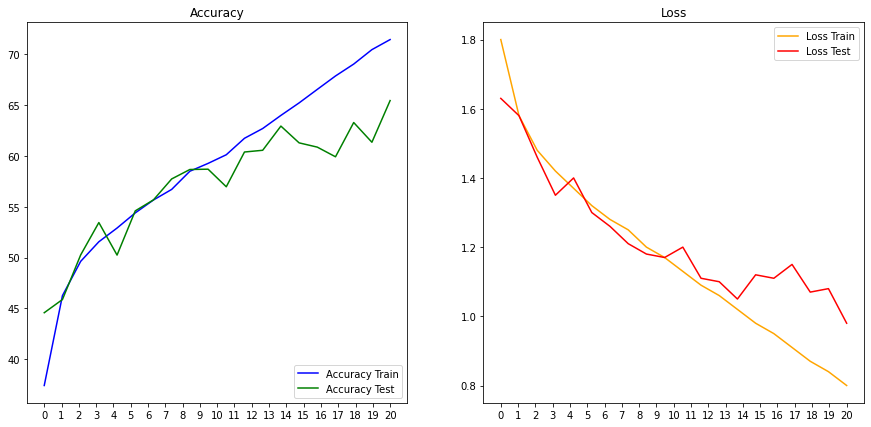

In [ ]:
plot(checkpoint_path,1)

In questo caso la rete dopo la 14-esima epoca tende a non avere miglioramenti sul test set.

### Test Suite

In [ ]:
numBatch = 4
size = 120

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
y_true, y_pred = classify(model, testLoader)

2781/2782
 Accuracy della rete composta da 11126 video: 59.51824555096171


In [ ]:
report = classification_report(y_true, y_pred)
print(report)
c3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
c3d_name.append('T.L')

              precision    recall  f1-score   support

           0       0.78      0.30      0.43       272
           1       0.19      0.04      0.07       297
           2       0.77      0.52      0.62      1827
           3       0.48      0.61      0.54      1060
           4       0.60      0.05      0.09       128
           5       0.34      0.53      0.42       678
           6       0.48      0.72      0.57      1181
           7       0.82      0.04      0.08       207
           8       0.65      0.74      0.69      1962
           9       0.69      0.64      0.66      3514

    accuracy                           0.60     11126
   macro avg       0.58      0.42      0.42     11126
weighted avg       0.62      0.60      0.59     11126



### Confronto
La C3D ha mostrato il grande potenziale del Transfer Learning, infatti siamo passati da un modello per niente affidabile a causa dei pochi video contenuti nel dataset SpaceJam ad un altro che offre delle performance, seppur contenute, accettabili.


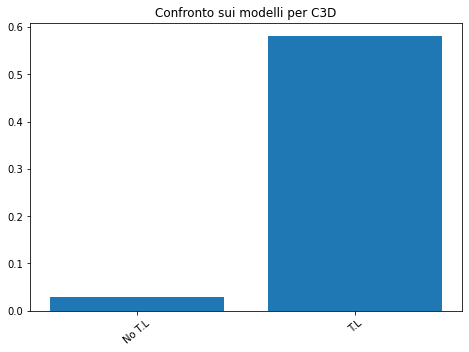

In [ ]:
bar_plot(c3d_precision,c3d_name, 'C3D')

# R3D
---
La rete ResNet3D si basa sull’architettura ResNet, che introduce collegamenti di scelta rapida che bypassano un segnale da uno strato all'altro. Questo tipo di collegamenti facilitano l'addestramento di reti molto profonde.
A differenze delle architetture tradizionali ResNet, qui si utilizzano dei kernel convoluzionali 3x3x3 e kernel di pooling 3x3x3.

Sulla rete sono state effettuate diverse prove:
1. training senza transfer learning
2. R3D-18 con transfer learning su Kinetics
3. R3D-100 con transfer learning su Kinetics e Time in moment


## R3D-18 senza Transfer Learning

In [ ]:
from torchvision import models
model = models.video.r3d_18(pretrained=False, progress = True)
model.fc= nn.Linear(512,10)

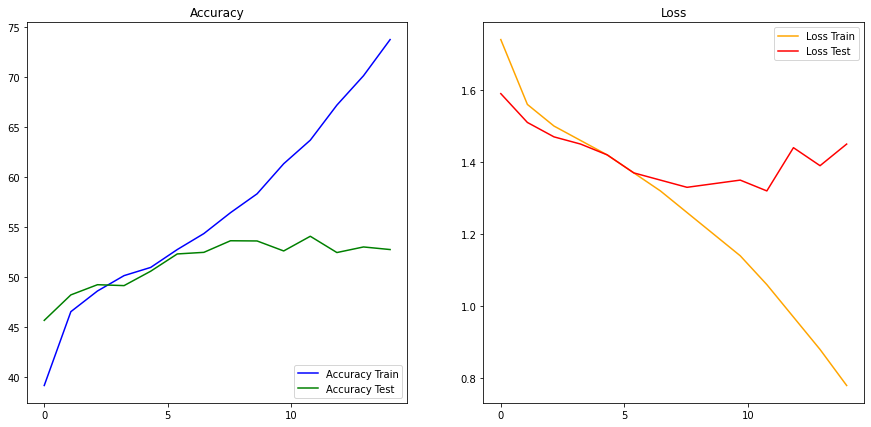

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'r3d_nopretrained'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
plot(checkpoint_path,5)

### Test suite


In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(model, checkpoint_path).to(device)
y_true, y_pred = classify(model, testLoader)
report = classification_report(y_true, y_pred)
print(report)
r3d_precision=[]
r3d_name=[]
r3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r3d_name.append('r3d-18-NoTransferLearning')

695/696
 Accuracy della rete composta da 11126 video: 53.46036311342801
              precision    recall  f1-score   support

           0       0.36      0.36      0.36       272
           1       0.14      0.01      0.02       297
           2       0.55      0.62      0.58      1827
           3       0.51      0.31      0.39      1060
           4       0.64      0.16      0.26       128
           5       0.30      0.24      0.27       678
           6       0.43      0.50      0.46      1181
           7       1.00      0.00      0.01       207
           8       0.60      0.63      0.62      1962
           9       0.58      0.68      0.62      3514

    accuracy                           0.53     11126
   macro avg       0.51      0.35      0.36     11126
weighted avg       0.53      0.53      0.52     11126



## R3D-18 con Transfer Learning

In [ ]:
from torchvision import models
model = models.video.r3d_18(pretrained=False, progress = True)
model.fc= nn.Linear(512,10)

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'r3d_pretrained'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

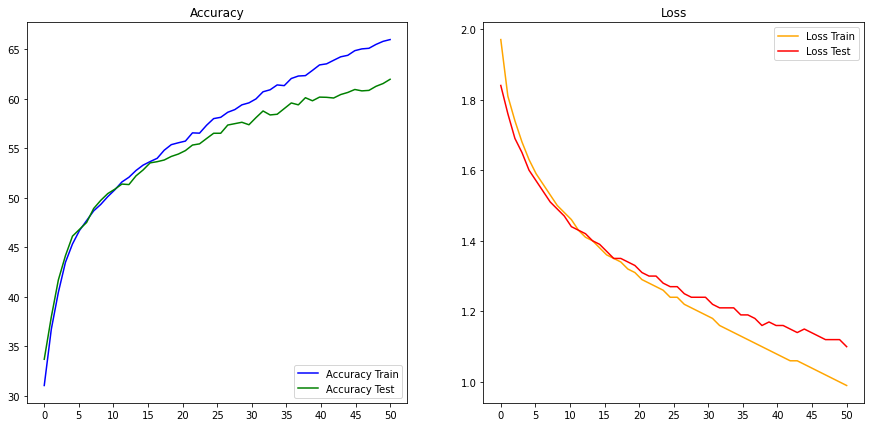

In [ ]:
plot(checkpoint_path,5)

L'addestramento è stato fermato all'epoca in cui cominciava ad andare in overfitting.

### Test Suite

In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:

y_true, y_pred = classify(model, testLoader)


695/696
 Accuracy della rete composta da 11126 video: 61.51357181376955


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.35      0.41       272
           1       0.43      0.01      0.02       297
           2       0.64      0.70      0.67      1827
           3       0.63      0.56      0.59      1060
           4       0.00      0.00      0.00       128
           5       0.43      0.36      0.39       678
           6       0.57      0.50      0.54      1181
           7       0.33      0.00      0.01       207
           8       0.66      0.66      0.66      1962
           9       0.62      0.78      0.69      3514

    accuracy                           0.62     11126
   macro avg       0.48      0.39      0.40     11126
weighted avg       0.59      0.62      0.59     11126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

r3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r3d_name.append('r3d-18- TransferLearning')

## R3D-200 con transfer learning

In [ ]:
# Modello R3D con depth 200

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=1039):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

model=generate_model(200)
model.fc=nn.Linear(2048, 10)
model.add_module('relu',nn.ReLU())
model.add_module('softmax',nn.Softmax())

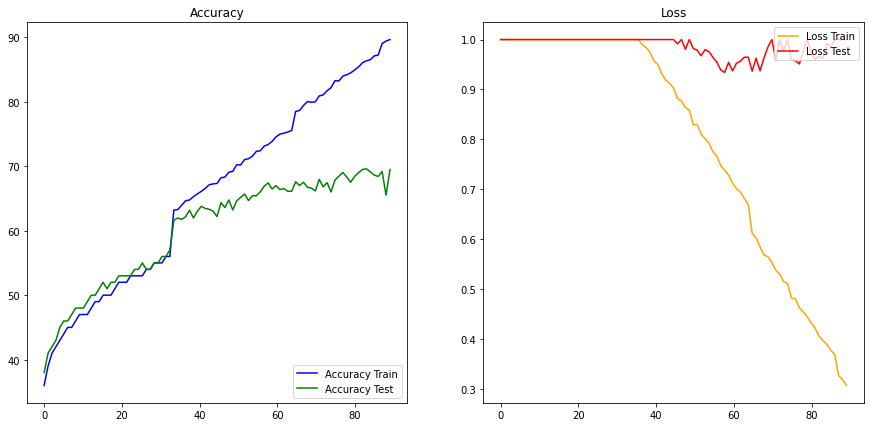

In [ ]:
#loss e accuracy del training
path_model=path_checks+'r3d200'
plot(path_model+'/r3d200',20,type='csv')

Il grafico dimostra come dalla 50-esima epoca in poi non si hanno miglioramenti sul test set.

### Test Suite

In [ ]:
path_model = '/content/drive/My Drive/spacejam'

In [ ]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.00086)
load_model,_, _=load_ckp(path_model, model, optimizer)
load_model.cuda()

ResNet(
  (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64, 256, kernel_size=(

In [ ]:
numBatch = 12
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()), 'test_video',size,0)
testLoader = torch.utils.data.DataLoader(test_set, **params)

y_true, y_pred = classify(load_model, testLoader)
report = classification_report(y_true, y_pred)
print(report)
r3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r3d_name.append('r3d-200')

927/928
 Accuracy della rete composta da 11126 video: 56.66007549883157
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       272
           1       0.34      0.31      0.32       297
           2       0.67      0.57      0.62      1827
           3       0.69      0.57      0.62      1060
           4       0.59      0.39      0.47       128
           5       0.53      0.45      0.48       678
           6       0.53      0.46      0.50      1181
           7       0.51      0.24      0.32       207
           8       0.54      0.62      0.58      1962
           9       0.54      0.64      0.59      3514

    accuracy                           0.57     11126
   macro avg       0.55      0.47      0.50     11126
weighted avg       0.57      0.57      0.56     11126



### Same aspect ratio

E' stato effettuato un ulteriore addestramento della rete con le immagini ridimensionate (150x150), impedendo la deformazione dell'immagine con l'aggiunta dei bordi neri.

Sono bastate poche epoche per raggiungere un buon risultato.


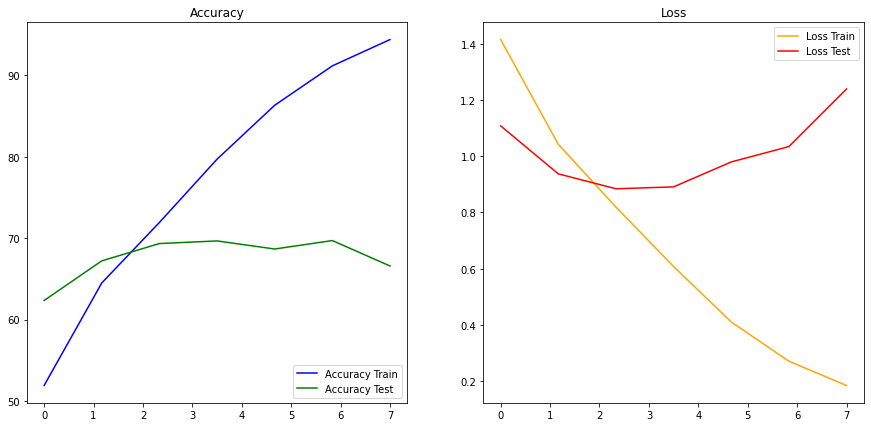

In [ ]:
#Caricamento modello

#plot di loss e acc
#loss e accuracy del training
path_model= path_checks+'r3dBordi'
plot(path_model+'/r3dBordi',1,type='csv')

#### Test Suite

In [ ]:
numBatch = 10
size = 150

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDatasetSAR(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)


#
model=generate_model(200)
model.fc=nn.Linear(2048, 10)
model.cuda();
#

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
load_model,_, _=load_ckp(path_model, model, optimizer)
load_model.cuda()
y_true, y_pred = classify(load_model, testLoader)
report = classification_report(y_true, y_pred)
print(report)

r3d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r3d_name.append('r3d-200 SAR')

1112/1113
 Accuracy della rete composta da 11126 video: 68.14668344418479
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       272
           1       0.39      0.28      0.32       297
           2       0.77      0.68      0.72      1827
           3       0.80      0.69      0.74      1060
           4       0.62      0.47      0.53       128
           5       0.61      0.57      0.59       678
           6       0.62      0.60      0.61      1181
           7       0.46      0.35      0.40       207
           8       0.68      0.76      0.72      1962
           9       0.69      0.75      0.72      3514

    accuracy                           0.68     11126
   macro avg       0.62      0.57      0.59     11126
weighted avg       0.68      0.68      0.68     11126



## Confronto


Segue un confronto dei modelli allenati.

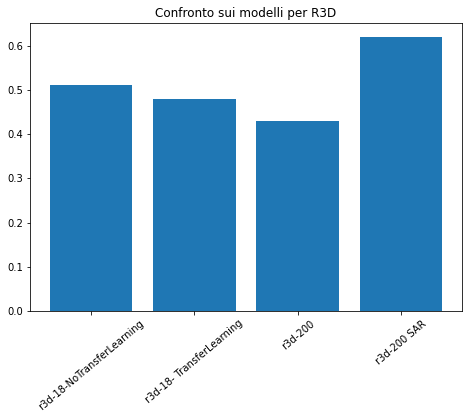

In [ ]:
bar_plot(r3d_precision, r3d_name, 'R3D')

# R(2+1)D

L’architettura R(2+1)D è una variante spazio-temporale dell’architettura ResNet3D ed è formata da un blocco convoluzionale “(2 + 1) D”, che esplicitamente fattorizza la convoluzione 3D in due operazioni separate e successive: una convoluzione spaziale 2D e una convoluzione temporale 1D.

Un vantaggio potenziale è che la decomposizione facilita l'ottimizzazione, producendo in pratica sia una loss inferiore sul training set sia una loss inferiore sul test set. In altre parole, rispetto ai filtri 3D completi in cui aspetto e dinamica sono congiunti, i blocchi (2 + 1)D (con componenti spaziali e temporali fattorizzati) sono più facili da ottimizzare.

Questa è l'architettura di rete scelta. Sono state effettuate tante prove:
1. Senza transfer learning
2. Senza transfer learning con due layer freezzati
3. Transfer learnig su Kinetics400
4. Transfer learnig su Kinetics600 e Moments In Time
5. Transfer learnig su IG65+Kinetics400

In [ ]:
r21d_precision=[]
r21d_name=[]

## R(2+1)D senza Transfer Learning

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'r(2+1)d_no-pretrained'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

Sono presentate le curve di loss ed accuracy: il modello, ancora una volta, è stato fermato quando non aveva miglioramenti sul test.

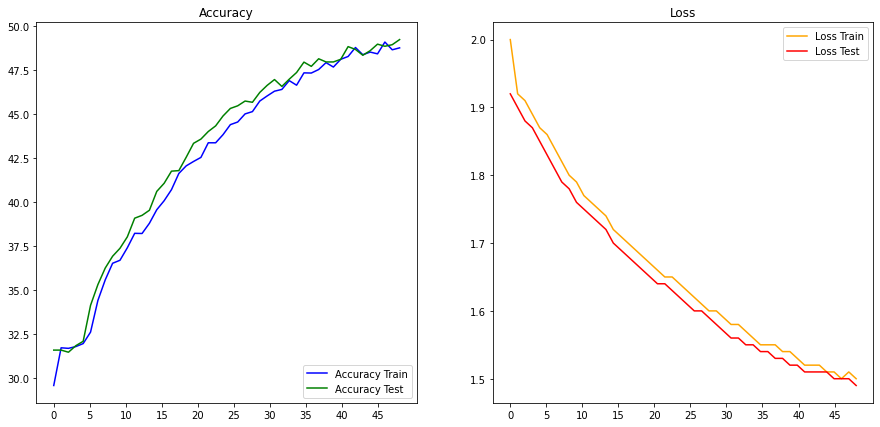

In [ ]:
plot(checkpoint_path,5)

### Test Suite

In [ ]:
from torchvision import models
model = models.video.r2plus1d_18(pretrained=False, progress=True)
model.fc= nn.Linear(512,10)

In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video',size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
y_true, y_pred = classify(model, testLoader) #lr=1e-4

695/696
 Accuracy della rete composta da 11126 video: 49.119180298400146


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('No T.L')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       272
           1       0.00      0.00      0.00       297
           2       0.49      0.63      0.55      1827
           3       0.40      0.10      0.16      1060
           4       0.00      0.00      0.00       128
           5       1.00      0.00      0.00       678
           6       0.42      0.30      0.35      1181
           7       0.00      0.00      0.00       207
           8       0.61      0.57      0.59      1962
           9       0.47      0.78      0.59      3514

    accuracy                           0.49     11126
   macro avg       0.34      0.24      0.22     11126
weighted avg       0.48      0.49      0.43     11126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## R(2+1)D 2 layer freezati

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'r(2+1)d_freeze_first2layer'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

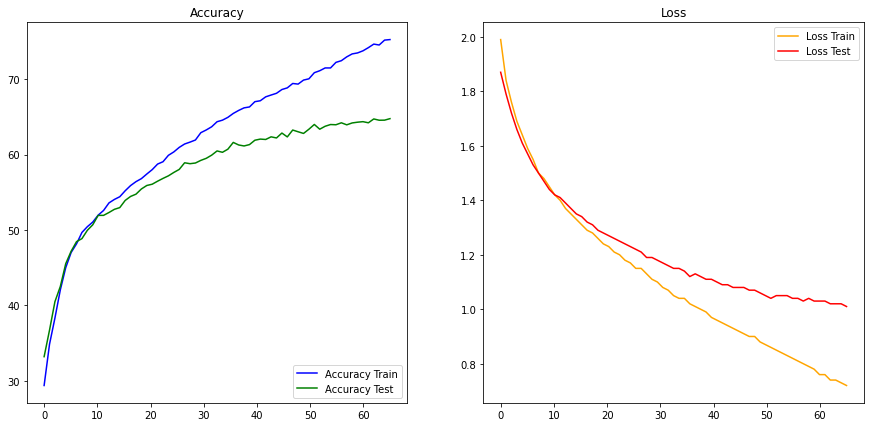

In [ ]:
plot(checkpoint_path,10)

Il modello raggiunge la convergenza dopo la 50-esima epoca circa. E' stato addestrato per più epoche, ma poi riportato al punto in cui aveva sul test migliori valori.

### Test Suite

In [ ]:
from torchvision import models
model = models.video.r2plus1d_18(pretrained=False, progress=True)
model.fc = nn.Linear(512,10)

In [ ]:
#freeze first 2 ConvLayer
for param in model.stem.parameters():
  param.requires_grad = False
for param in model.layer1.parameters():
  param.requires_grad = False

In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video',size,2)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
y_true, y_pred = classify(model, testLoader)

695/696
 Accuracy della rete composta da 11126 video: 64.68632033075679


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.49      0.50       272
           1       0.21      0.02      0.03       297
           2       0.69      0.74      0.71      1827
           3       0.71      0.67      0.69      1060
           4       0.00      0.00      0.00       128
           5       0.47      0.49      0.48       678
           6       0.57      0.55      0.56      1181
           7       0.67      0.05      0.09       207
           8       0.68      0.67      0.67      1962
           9       0.66      0.77      0.71      3514

    accuracy                           0.65     11126
   macro avg       0.52      0.44      0.44     11126
weighted avg       0.63      0.65      0.63     11126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Non si ottiene un cattivo punteggio, ma sono stati addestrati modelli migliori.

In [ ]:
r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('No T.L.-freez')

## R(2+1)D con transfer learning (Kinetics400)

Il modello è stato addestrato su immagini di size (112,112). Sono state fatte circa 100 epoche ed è stato bloccato in quanto andando avanti non aveva ulteriori miglioramenti.

In [ ]:
model=torchvision.models.video.r2plus1d_18( pretrained = False, progress = True)
model.fc=nn.Linear(512,10, bias=True)
model.add_module('relu',nn.ReLU())
model.add_module('softmax',nn.Softmax())

path_model=path_checks+'r21dK'

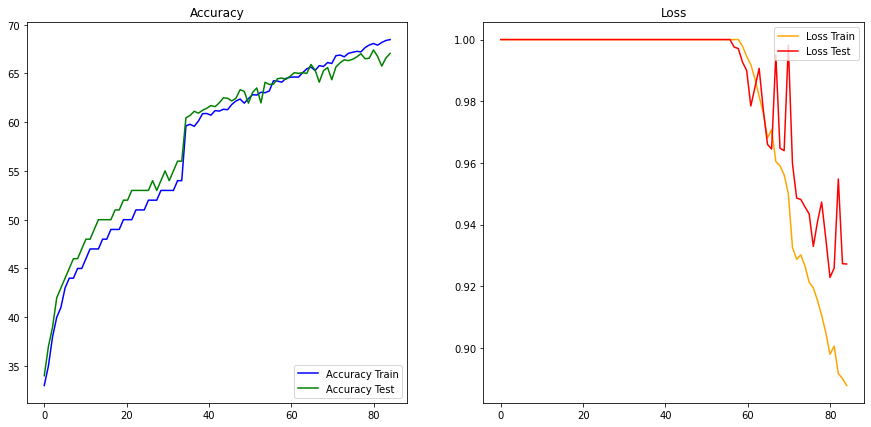

In [ ]:
#loss e accuracy del training
plot(path_model+'/r21dK',20,type='csv')

### Test Suite

In [ ]:

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
load_model,_, _=load_ckp(path_model, model, optimizer)
load_model.cuda();

In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()), 'test_video',size,1)
testLoader = torch.utils.data.DataLoader(test_set, **params)

y_true, y_pred = classify(model, testLoader)

report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('Kinetcs400')

695/696
 Accuracy della rete composta da 11126 video: 54.72766492899515
              precision    recall  f1-score   support

           0       0.42      0.43      0.42       272
           1       0.22      0.06      0.10       297
           2       0.66      0.53      0.59      1827
           3       0.59      0.61      0.60      1060
           4       0.48      0.11      0.18       128
           5       0.38      0.38      0.38       678
           6       0.55      0.44      0.49      1181
           7       0.32      0.09      0.14       207
           8       0.58      0.50      0.54      1962
           9       0.53      0.72      0.61      3514

    accuracy                           0.55     11126
   macro avg       0.47      0.39      0.40     11126
weighted avg       0.54      0.55      0.53     11126



## R(2+1)D con transfer learning (Kinetic600 e Moments in time)

In [ ]:
#caricamento del modello

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

def get_inplanes():
    return [64, 128, 256, 512]

def conv1x3x3(in_planes, mid_planes, stride=1):
    return nn.Conv3d(in_planes,
                     mid_planes,
                     kernel_size=(1, 3, 3),
                     stride=(1, stride, stride),
                     padding=(0, 1, 1),
                     bias=False)

def conv3x1x1(mid_planes, planes, stride=1):
    return nn.Conv3d(mid_planes,
                     planes,
                     kernel_size=(3, 1, 1),
                     stride=(stride, 1, 1),
                     padding=(1, 0, 0),
                     bias=False)

def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        n_3d_parameters1 = in_planes * planes * 3 * 3 * 3
        n_2p1d_parameters1 = in_planes * 3 * 3 + 3 * planes
        mid_planes1 = n_3d_parameters1 // n_2p1d_parameters1
        self.conv1_s = conv1x3x3(in_planes, mid_planes1, stride)
        self.bn1_s = nn.BatchNorm3d(mid_planes1)
        self.conv1_t = conv3x1x1(mid_planes1, planes, stride)
        self.bn1_t = nn.BatchNorm3d(planes)

        n_3d_parameters2 = planes * planes * 3 * 3 * 3
        n_2p1d_parameters2 = planes * 3 * 3 + 3 * planes
        mid_planes2 = n_3d_parameters2 // n_2p1d_parameters2
        self.conv2_s = conv1x3x3(planes, mid_planes2)
        self.bn2_s = nn.BatchNorm3d(mid_planes2)
        self.conv2_t = conv3x1x1(mid_planes2, planes)
        self.bn2_t = nn.BatchNorm3d(planes)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1_s(x)
        out = self.bn1_s(out)
        out = self.relu(out)
        out = self.conv1_t(out)
        out = self.bn1_t(out)
        out = self.relu(out)

        out = self.conv2_s(out)
        out = self.bn2_s(out)
        out = self.relu(out)
        out = self.conv2_t(out)
        out = self.bn2_t(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)

        n_3d_parameters = planes * planes * 3 * 3 * 3
        n_2p1d_parameters = planes * 3 * 3 + 3 * planes
        mid_planes = n_3d_parameters // n_2p1d_parameters
        self.conv2_s = conv1x3x3(planes, mid_planes, stride)
        self.bn2_s = nn.BatchNorm3d(mid_planes)
        self.conv2_t = conv3x1x1(mid_planes, planes, stride)
        self.bn2_t = nn.BatchNorm3d(planes)

        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2_s(out)
        out = self.bn2_s(out)
        out = self.relu(out)
        out = self.conv2_t(out)
        out = self.bn2_t(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)


        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=1039):

        super().__init__()
        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        n_3d_parameters = 3 * self.in_planes * conv1_t_size * 7 * 7
        n_2p1d_parameters = 3 * 7 * 7 + conv1_t_size * self.in_planes
        mid_planes = n_3d_parameters // n_2p1d_parameters

        self.conv1_s = nn.Conv3d(n_input_channels,
                                 mid_planes,
                                 kernel_size=(1, 7, 7),
                                 stride=(1, 2, 2),
                                 padding=(0, 3, 3),
                                 bias=False)
        self.bn1_s = nn.BatchNorm3d(mid_planes)
        self.conv1_t = nn.Conv3d(mid_planes,
                                 self.in_planes,
                                 kernel_size=(conv1_t_size, 1, 1),
                                 stride=(conv1_t_stride, 1, 1),
                                 padding=(conv1_t_size // 2, 0, 0),
                                 bias=False)

        self.bn1_t = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)

        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)

        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)

        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()
        out = torch.cat([out.data, zero_pads], dim=1)
        return out



    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))
        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)



    def forward(self, x):
        x = self.conv1_s(x)
        x = self.bn1_s(x)
        x = self.relu(x)
        x = self.conv1_t(x)
        x = self.bn1_t(x)
        x = self.relu(x)

        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]
    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)
    return model

model=generate_model(50)
model.fc=nn.Linear(2048,10)


### Immagini (112x112)

Viene addestrato il modello inizialmente sulle immagini 112x112, ovvero le size richieste dalla rete stessa.


In [ ]:
#Il modello inizialmente è stato addestarto senza aggiunta di alcun livello di dropout
#In seguito, quando si è notato un discostamento tra la rete del training set e del test set, è stato aggiunto il livello di dropout.

path_model=path_checks+'r21dK600M'

La curva della loss e dell'accuracy è la seguente:

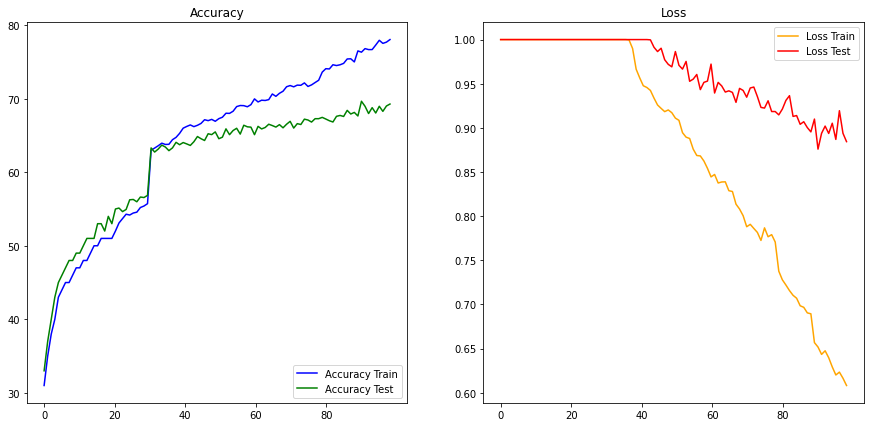

In [ ]:
#loss e accuracy del training
plot(path_model+'/r21dK600M',20,type='csv')

#### Test Suite

Valutazione del modello addestrato fino all'epoca 100.

In [ ]:

load_model,_, _=load_ckp(path_model, model, optimizer)
load_model.cuda();

In [ ]:
numBatch = 12
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()), 'test_video',size, 1)
testLoader = torch.utils.data.DataLoader(test_set, **params)

y_true, y_pred = classify(load_model, testLoader)
report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('Kin600-M (112x112)')

927/928
 Accuracy della rete composta da 11126 video: 52.049253999640484
              precision    recall  f1-score   support

           0       0.39      0.26      0.31       272
           1       0.21      0.15      0.18       297
           2       0.62      0.48      0.54      1827
           3       0.55      0.57      0.56      1060
           4       0.37      0.16      0.23       128
           5       0.37      0.36      0.36       678
           6       0.55      0.38      0.45      1181
           7       0.29      0.22      0.25       207
           8       0.52      0.55      0.53      1962
           9       0.53      0.67      0.59      3514

    accuracy                           0.52     11126
   macro avg       0.44      0.38      0.40     11126
weighted avg       0.52      0.52      0.51     11126



### Immagini (170x170)

Il modello è stato addestrato su immagini di size (170x170). Dopo la 25-epoca è stato aggiunto un livello di dropout.

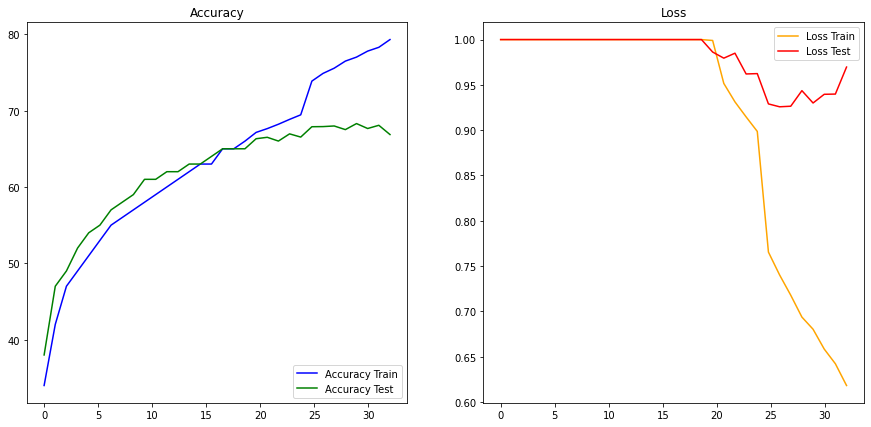

In [ ]:
#loss e accuracy del training
path_model= path_checks+'r21d170'
plot(path_model+'/r21d170',5,type='csv')

In [ ]:
numBatch = 12
size = 170

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8
test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()), 'test_video',size,0)
testLoader = torch.utils.data.DataLoader(test_set, **params)

#### Test Suite

In [ ]:
model=generate_model(50)
model.fc=nn.Linear(2048,10)

path_model=path_checks+'r21d170'
optimizer=torch.optim.SGD(model.parameters(), lr=0.0001)

load_model,_, _=load_ckp(path_model, model, optimizer)
load_model.cuda();

In [ ]:
y_true, y_pred = classify(load_model, testLoader)
report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('Kin600-M (170x170)')

927/928
 Accuracy della rete composta da 11126 video: 64.10210318173647
              precision    recall  f1-score   support

           0       0.47      0.52      0.49       272
           1       0.50      0.00      0.01       297
           2       0.67      0.73      0.70      1827
           3       0.68      0.66      0.67      1060
           4       0.00      0.00      0.00       128
           5       0.41      0.46      0.43       678
           6       0.54      0.52      0.53      1181
           7       0.00      0.00      0.00       207
           8       0.69      0.68      0.69      1962
           9       0.68      0.77      0.72      3514

    accuracy                           0.64     11126
   macro avg       0.46      0.43      0.42     11126
weighted avg       0.62      0.64      0.62     11126



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Modifiche al livello di dropout ed al learning rate

Provando a modificare il livello di dropout con p=0.5 ed il learning rate pari a 0.01, sono visibili i miglioramenti.

In [ ]:
model=generate_model(50)
model.fc=nn.Linear(2048,10)

path_model=path_checks+'r21dDropout'
optimizer=torch.optim.SGD(model.parameters(), lr=0.01)
load_model,_, _=load_ckp(path_model, model, optimizer)

Viene plottata la curva di loss e accuracy.


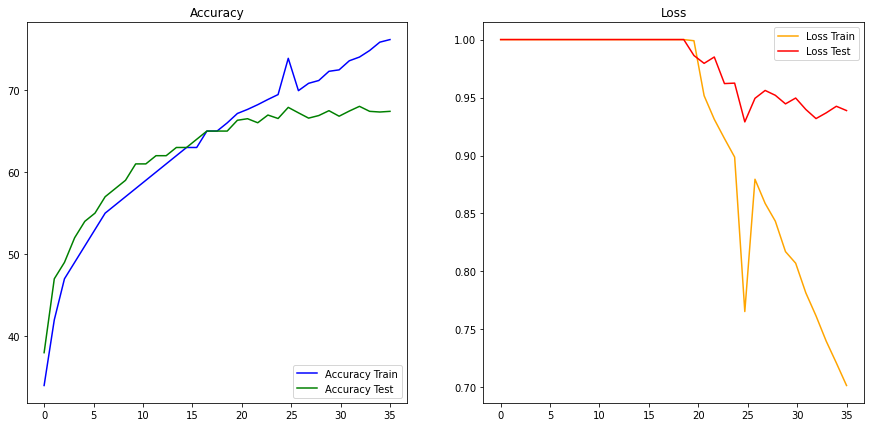

In [ ]:
#loss e accuracy del training
plot(path_model+'/r21dDropout',5,type='csv')

#####Test suite

In [ ]:
load_model.cuda()
y_true, y_pred = classify(load_model, testLoader)
report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('Kin600-M(170x170) 2')

927/928
 Accuracy della rete composta da 11126 video: 65.00089879561388
              precision    recall  f1-score   support

           0       0.44      0.54      0.48       272
           1       0.30      0.02      0.04       297
           2       0.70      0.71      0.70      1827
           3       0.69      0.72      0.70      1060
           4       0.64      0.05      0.10       128
           5       0.44      0.52      0.48       678
           6       0.57      0.55      0.56      1181
           7       0.34      0.06      0.11       207
           8       0.67      0.70      0.69      1962
           9       0.69      0.75      0.72      3514

    accuracy                           0.65     11126
   macro avg       0.55      0.46      0.46     11126
weighted avg       0.64      0.65      0.64     11126



Il modello ha ottenuto prestazioni migliori.

## R(2+1)D con transfer learning (IG65 + Kinetic) - same aspect ratio

Si utilizza un nuovo preprocessing: quello che mantiene l'aspect ratio. Prima viene testato con dimensioni delle immagini (112,112).

In [ ]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D
def r2plus1d_34(num_classes, progress=False, arch=None):
    model = VideoResNet(block=BasicBlock,
                        conv_makers=[Conv2Plus1D] * 4,
                        layers=[3, 4, 6, 3],
                        stem=R2Plus1dStem)

    model.fc = nn.Linear(model.fc.in_features, out_features=num_classes)

    model.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
    model.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
    model.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

    for m in model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eps = 1e-3
            m.momentum = 0.9


    return model

In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'/r(2+1)d_batch16_kinetic+ig65_(112,112)-same-aspect-ratio'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

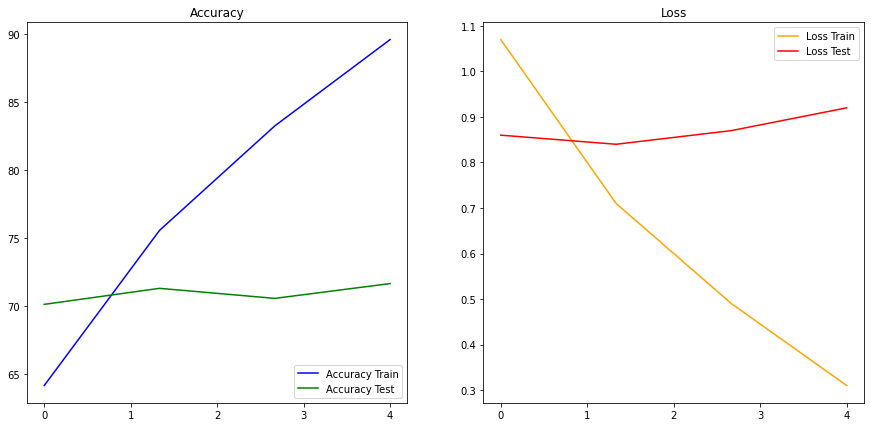

In [ ]:
plot(checkpoint_path,1)

### Test Suite

In [ ]:
model = r2plus1d_34(400)
model.fc= nn.Linear(512,10)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
numBatch = 16
size = 112

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDatasetSAR(list(annotationTest.keys()), list(annotationTest.values()),'test_video',size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
y_true, y_pred = classify(model, testLoader)

695/696
 Accuracy della rete composta da 11126 video: 71.46323925939241


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('IG65-Kin')

              precision    recall  f1-score   support

           0       0.72      0.28      0.41       272
           1       0.52      0.29      0.37       297
           2       0.83      0.75      0.79      1827
           3       0.90      0.74      0.81      1060
           4       0.75      0.34      0.47       128
           5       0.64      0.63      0.63       678
           6       0.61      0.67      0.64      1181
           7       0.57      0.38      0.45       207
           8       0.69      0.78      0.73      1962
           9       0.70      0.79      0.74      3514

    accuracy                           0.71     11126
   macro avg       0.69      0.56      0.60     11126
weighted avg       0.72      0.71      0.71     11126



## R(2+1)D IG65+Kinetics 150x150 same aspect ratio


In [ ]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D
def r2plus1d_34(num_classes, progress=False, arch=None):
    model = VideoResNet(block=BasicBlock,
                        conv_makers=[Conv2Plus1D] * 4,
                        layers=[3, 4, 6, 3],
                        stem=R2Plus1dStem)

    model.fc = nn.Linear(model.fc.in_features, out_features=num_classes)

    # Fix difference in PyTorch vs Caffe2 architecture
    # https://github.com/facebookresearch/VMZ/issues/89
    # https://github.com/pytorch/vision/issues/1265
    model.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
    model.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
    model.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

    # We need exact Caffe2 momentum for BatchNorm scaling
    for m in model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eps = 1e-3
            m.momentum = 0.9


    return model

In generale, la rete si è comportata da subito bene: per le prime tre epoche è stata addestrata con optimizer SGD e learning rate 0.001, poiché andando avanti con le iterazioni aumentavano solo le performance del training, è stato aggiunto un livello di dropout con p=0.5 e decrementato il learning rate a 0.0001.
Il modello riportato è quello ottenuto dopo 4 epoche di addestramento, in quanto andando avanti non si verificano miglioramenti delle performance sul test.


In [ ]:
from pathlib import Path
checkpoint_path = path_checks+'r(2+1)d_batch16_kinetic+ig65_(150,150)-same-aspect-ratio_lr=1e-3_dropout50%-lr=1e-4'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

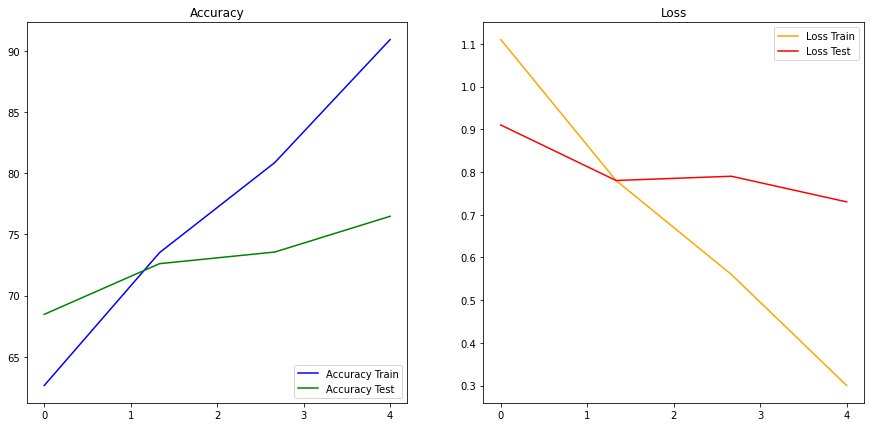

In [ ]:
plot(checkpoint_path,1)

###Test suite

In [ ]:
model = r2plus1d_34(400)
model.fc= nn.Linear(512,10)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
numBatch = 8
size = 150

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDatasetSAR(list(annotationTest.keys()), list(annotationTest.values()),'test_video', size)
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
y_true, y_pred = classify(model, testLoader)

1390/1391
 Accuracy della rete composta da 11126 video: 76.46054287255077


In [ ]:
report = classification_report(y_true, y_pred)
print(report)
r21d_precision.append(float(report.split('macro avg ',2)[1].split(' ')[6]))
r21d_name.append('IG65-Kin-(150x150 SAR)')

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       272
           1       0.60      0.47      0.53       297
           2       0.82      0.84      0.83      1827
           3       0.88      0.86      0.87      1060
           4       0.64      0.53      0.58       128
           5       0.75      0.73      0.74       678
           6       0.71      0.67      0.69      1181
           7       0.61      0.49      0.55       207
           8       0.76      0.75      0.76      1962
           9       0.76      0.80      0.78      3514

    accuracy                           0.76     11126
   macro avg       0.72      0.68      0.70     11126
weighted avg       0.76      0.76      0.76     11126



## Confronto

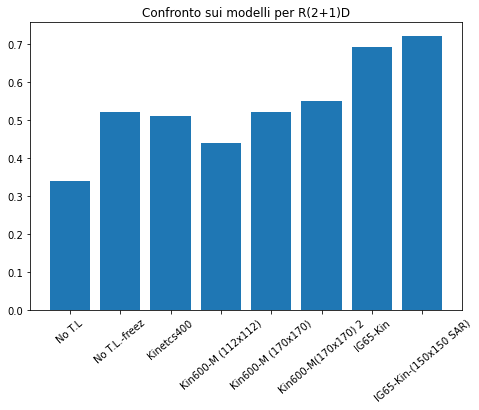

In [ ]:
bar_plot(r21d_precision,r21d_name, 'R(2+1)D')

Il modello che si comporta in maniera ottimale è 'IG65-Kin-(150x150 SAR)'

# Conclusione
Si prendono in esame i valori di precisione media migliori per ogni modello.

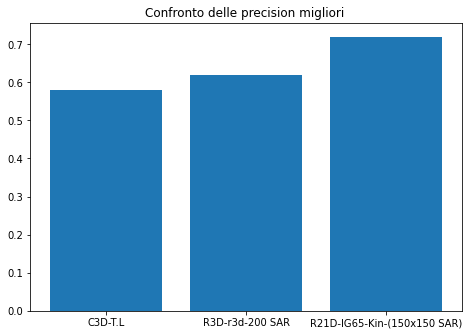

In [ ]:
best_values=[]
best_values.append(max(c3d_precision))
best_values.append(max(r3d_precision))
best_values.append(max(r21d_precision))
net_names=[]
net_names.append('C3D-'+c3d_name[np.argmax(c3d_precision)])
net_names.append('R3D-'+r3d_name[np.argmax(r3d_precision)])
net_names.append('R21D-'+r21d_name[np.argmax(r21d_precision)])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(net_names,best_values, label=['type', 'precision'])
plt.title("Confronto delle precision migliori ")
plt.show()
